# homework1.1

## 1  生成root文件

模拟生成100000个事件，其中3成是光子，7成是中子
探测装置具有如下的参数
+ 靶和闪烁体中心距离`D` 500cm
+ 闪烁体的半长 `L` 100cm
+ 闪烁体的厚度 `dD` 5cm

In [1]:
// 运行方法：
// 将下列代码保存到tree.cc
// 在ROOT环境中运行：
// root -l //进入ROOT环境
// .x tree.cc //运行脚本
// .q //退出root环境
// root -l tree.root //打开ROOT文件
void tree(){ 
//常量声明
  const Double_t D=500.;//cm, distance between target and the scin.(Center)
  const Double_t L=100.;//cm, half length of the scin.
  const Double_t dD=5.;//cm, thickness of the scin.
  const Double_t TRes=1.;//ns, time resolution(FWHM) of the scintillator.
  const Double_t Lambda=380.;//cm, attenuation lenght of the scin.
  const Double_t QRes=0.1;//relative energy resolution(FWHM) of the scin. 
  const Double_t Vsc=7.5;//ns/cm, speed of light in the scin.
  const Double_t En0=100;//MeV, average neutron energy
  const Double_t EnRes=50.;//MeV, energy spread of neutron(FWHM)
  const Double_t Eg0=1;//MeV, gamma energy  
  const Double_t Rg=0.3;//ratio of gamma,ratio of neutron 1-Rg 

  //1. 声明在tree结构中定义需要的变量分支
  Double_t x;//入射位置
  Double_t e;//能量
  int pid;    //粒子种类，n:pid=1,g:pid=0
  Double_t tof, ctof;//TOF:粒子实际飞行时间，cTOF：计算得到的TOF
  Double_t tu, td;
  Double_t qu, qd;

  Double_t tu_off=5.5;//time offset，//PMT的度越时间+电缆上的传输时间
  Double_t td_off=20.4;//time offset 

 //2. 定义新ROOT文件，声明新的Tree 
  TFile *opf=new TFile("tree.root","recreate");//新文件tree.root，指针 *opf
  TTree *opt=new TTree("tree","tree structure");//新tree，指针 *opt

  //3. 将变量地址添加到tree结构中
    //第一个参数为变量名称，第二个为上面定义的变量地址，第三个为变量的类型说明，D表示Double_t，I表示 Int_t。
  opt->Branch("x", &x, "x/D");
  opt->Branch("e", &e, "e/D");
  opt->Branch("tof", &tof, "tof/D");
  opt->Branch("ctof",&ctof,"ctof/D");
  opt->Branch("pid", &pid, "pid/I");
  opt->Branch("tu", &tu, "tu/D");
  opt->Branch("td", &td, "td/D");
  opt->Branch("qu", &qu, "qu/D"); 
  opt->Branch("qd", &qd, "qd/D");  

// histogram，ROOT文件中除了TTree结构外，还可存储histogram，graph等
  TH1D *hctof=new TH1D("hctof","neutron time of flight",1000,0,100);
  TRandom3 *gr=new TRandom3(0);//声明随机数

  //4. 循环，计算变量的值，逐事件往tree结构添加变量值。
  for(int i=0;i<100000;i++){
    x=gr->Uniform(-L, L);//粒子入射位置，在-L,L范围内均匀抽样.
    Double_t Dr=D+gr->Uniform(-0.5,0.5)*dD;//粒子在探测器厚度范围内均匀产生光信号
    Double_t d=TMath::Sqrt(Dr*Dr+x*x);//粒子实际飞行距离，flight path
    if(gr->Uniform() < Rg) { //判断为gamma入射
       pid=0;
       e=Eg0;
       tof=3.333*(d*0.01);
    }
    else {  //neutron
        pid=1;
        e=gr->Gaus(En0, EnRes/2.35); // energy of neutrons
        tof=72.29824/TMath::Sqrt(e)*(d*0.01);//ns
    }
    tu=tof+(L-x)/Vsc+gr->Gaus(0,TRes/2.35)+tu_off;
    td=tof+(L+x)/Vsc+gr->Gaus(0,TRes/2.35)+td_off;
    ctof=(tu+td)/2.;//simplified calculation.
    hctof->Fill(ctof);
//neutron：energy of recoil proton in plas. q0=0-En； gamma：q0=0-Egamma，compton plateau
    Double_t q0=e*gr->Uniform();
    qu=q0*TMath::Exp(-(L-x)/Lambda);
    qu=gr->Gaus(qu,qu*QRes/2.35);//QRes, relative energy resolution
    qd=q0*TMath::Exp(-(L+x)/Lambda);
    qd=gr->Gaus(qd,qd*QRes/2.35);
    opt->Fill();//5.将计算好的变量值填到Tree中

    if(i%1000==0) cout<<".";
  }
  cout<<endl;
  // 6.将数据写入root文件中
  hctof->Write();//写入预定义的histogram到文件
  opt->Write();//写入TTree到文件
  opf->Close();//关闭文件
}
// tree();

## 2 计算入射位置

### 2.0 准备

In [2]:
// %jsroot on
// 物理量定义
const Double_t c = 2.998e8;                     // 光速m/s
const Double_t nc = c * 1e-9;                   // 光速m/ns
const Double_t realTof0 = 5.025 / c * 1e9;      // 光子打在502.5cm外的探测器需要的飞行时间
const Double_t Mn = 939.57;                     // MeV/c^2

In [3]:
// 1.打开文件，得到TTree指针
TFile *ipf = new TFile("tree.root");//打开ROOT文件
if (ipf->IsZombie()) {
    cout << "Error opening file tree.root" << endl;
    exit(-1);
}
ipf->cd();
TTree *tree = (TTree*)ipf->Get("tree");//得到名字为“tree”的TTree指针

//2. 声明tree的Branch变量

Double_t x;
Double_t e;
int pid;
Double_t tof, ctof;
Double_t tu, td;
Double_t qu, qd;

//3. 将变量指向对应Branch的地址
tree->SetBranchAddress("ctof", &ctof);//将ROOT文件内tree内名为"ctof"的branch的数据的指针指向ctof的变量。
tree->SetBranchAddress("tof", &tof);
tree->SetBranchAddress("pid", &pid);
tree->SetBranchAddress("tu", &tu);
tree->SetBranchAddress("td", &td);
tree->SetBranchAddress("qu", &qu);
tree->SetBranchAddress("qd", &qd);
tree->SetBranchAddress("x", &x);
tree->SetBranchAddress("e", &e);

Double_t tp0, tp1;
Double_t txl, txr;
Double_t qp0, qp1;
Double_t qxl, qxr;
//new four parameters
Double_t tx, qx, ce, ntof;

Long64_t nentries = tree->GetEntries();//得到tree的事件总数

// 定义新的树
TFile *opf = new TFile("tree2.root", "recreate");
opf->cd();
TTree *opt = new TTree("tree", "tree");
// old data
opt->Branch("tu", &tu, "tu/D");
opt->Branch("td", &td, "td/D");
opt->Branch("qu", &qu, "qu/D");
opt->Branch("qd", &qd, "qd/D");
opt->Branch("x", &x, "x/D");
opt->Branch("e", &e, "e/D");
opt->Branch("pid", &pid, "pid/I");
opt->Branch("ctof", &ctof, "ctof/D");
opt->Branch("tof", &tof, "tof/D");
// new data
opt->Branch("tx", &tx, "tx/D");
opt->Branch("qx", &qx, "qx/D");
opt->Branch("ntof", &ntof, "ntof/D");
opt->Branch("ce", &ce, "ce/D");

TCanvas *c1 = new TCanvas("c1", "c1");

### 2.1 通过探测器两端的时间信号$t_u$和$t_d$

$$
t_u = TOF + (L - x) / v_{sc} + T_{uoff} \\
t_d = TOF + (L + x) / v_{sc} + T_{doff} \\
x = (t_d - t_u) \times v_{sc} / 2 + (T_{uoff} - T_{doff}) \times v_{sc} / 2 = p_0 + p_1 \times (t_d - t_u) \\
TOF = (t_d + t_u) / 2 - L / v_{sc} - (T_{uoff} + T_{doff}) / 2  = (t_d + t_u) / 2 + TOF_{fix}
$$

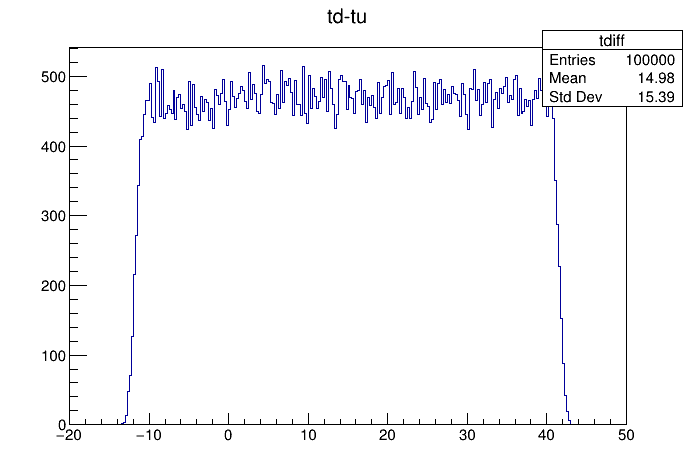

In [4]:
tree->Draw("td-tu>>tdiff(280, -20, 50)", "", "");
c1->Draw();
// TH1D *tdiff = new TH1D("tdiff", "td-tu", 280, -20, 50);
// for (Long64_t jentry = 0; jentry != nentries; ++jentry) {
//     tree->GetEntry(jentry);
//     tdiff->Fill(td-tu);
// }
// tdiff->Draw();
// c1->Draw();

**对上图进行微分并在两边进行高斯拟合，获得两边边界的值**

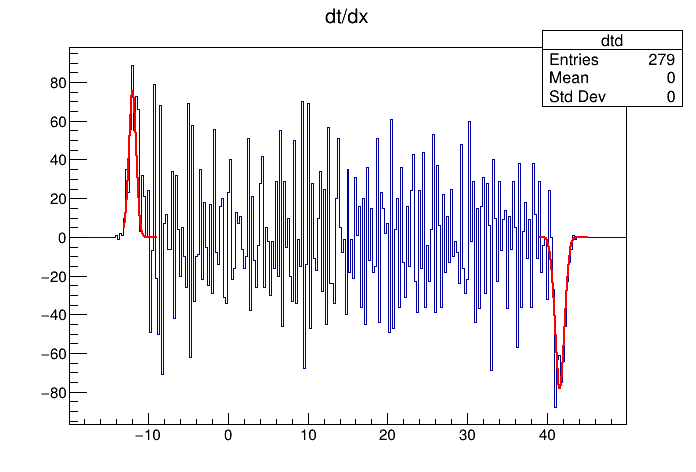

 FCN=146.913 FROM MIGRAD    STATUS=CONVERGED     110 CALLS         111 TOTAL
                     EDM=6.88356e-11    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   1.1 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant    -7.82002e+01   4.42609e+00  -3.02221e-04  -4.00276e-06
   2  Mean         4.15873e+01   3.40813e-02   2.15882e-05  -9.14164e-06
   3  Sigma        5.82572e-01   2.33915e-02   1.15546e-05   1.64799e-04
 FCN=300.997 FROM MIGRAD    STATUS=CONVERGED     107 CALLS         108 TOTAL
                     EDM=7.23373e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     7.52876e+01   5.52160e+00   3.45437e-02   1.19077e-05
   2  Mean        -1.19312e+01   2.92225e-02   2.12539e-04   3.42824e-04
   3  Sigma        4

In [5]:
TH1D *tdiff = (TH1D*)gDirectory->Get("tdiff");
TH1D *dtd = new TH1D("dtd", "dt/dx", 279, -19.875, 49.875);
Double_t lastBin = tdiff->GetBinContent(1);
for (int i = 2; i <= tdiff->GetNbinsX(); ++i) {
    Double_t bin = tdiff->GetBinContent(i);
    dtd->Fill(tdiff->GetBinLowEdge(i), bin-lastBin);
    lastBin = bin;
}
dtd->Sumw2(0);
dtd->Draw();
// 拟合
TF1 *f1 = new TF1("f1", "gaus", 39, 45);
TF1 *f2 = new TF1("f2", "gaus", -13, -9);
f1->SetParameters(-250, 42, 1.0);
dtd->Fit(f1, "RN", "");
dtd->Fit(f2, "R", "same");
f1->Draw("same");
c1->Draw();

**根据拟合结果，得到$t_x$的刻度结果**

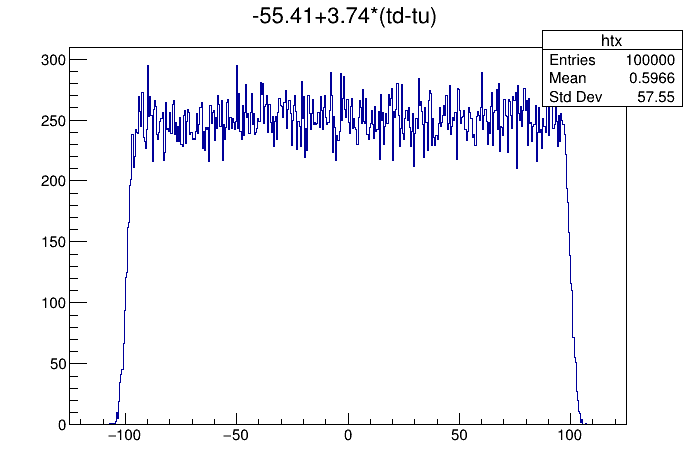

In [6]:
txl = f2->GetParameter(1);
txr = f1->GetParameter(1);
// tx = 200.0 / (txr - txl) * ((td-tu)-txl) - 100.0
// tp0 = 200.0 * txl / (txl-txr) - 100.0;
tp0 = 200.0 / (txl-txr) * (txl+txr)/2.0;
tp1 = 200.0 / (txr-txl);
TString stp0(Form("%5.2lf", tp0));
TString stp1(Form("%4.2lf", tp1));
tree->Draw(stp0+"+"+stp1+"*"+"(td-tu) >> htx(500, -125, 125)");
delete f1, f2;
c1->Draw();

### 2.2 通过探测器两端的能量信号$q_u$和$q_d$

$$
q_u = q_0 \exp[-(L-x)/\lambda] \\
q_d = q_0 \exp[-(L+x)/\lambda] \\
x = \ln\frac{q_u}{q_d} \times \lambda / 2 \\
q_0^2 = q_u \cdot q_d \cdot e^{2L / \lambda} \\
$$

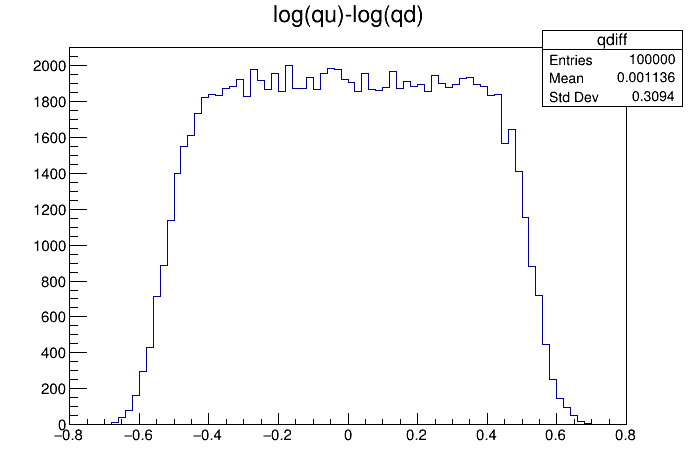

In [7]:
tree->Draw("log(qu)-log(qd)>>qdiff(80, -0.8, 0.8)", "", "");
c1->Draw();

**对上图进行微分，并拟合左右边界**

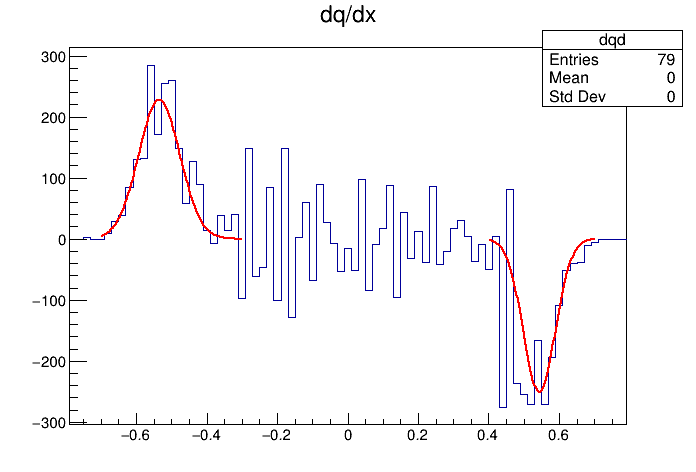

 FCN=384.673 FROM MIGRAD    STATUS=CONVERGED      63 CALLS          64 TOTAL
                     EDM=2.08827e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.27631e+02   7.06965e+00   5.37740e-02   8.83698e-07
   2  Mean        -5.33962e-01   1.50424e-03   1.44198e-05  -1.34950e-01
   3  Sigma        5.84590e-02   1.20385e-03   5.72484e-05  -3.13350e-03
 FCN=681.916 FROM MIGRAD    STATUS=CONVERGED     114 CALLS         115 TOTAL
                     EDM=3.34788e-10    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.0 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant    -2.50791e+02   8.42770e+00  -2.38001e-03  -5.34687e-07
   2  Mean         5.44411e-01   1.48015e-03   2.62458e-07  -7.52342e-03
   3  Sigma        4

In [8]:
TH1D *qdiff = (TH1D*)gDirectory->Get("qdiff");
TH1D *dqd = new TH1D("dqd", "dq/dx", 79, -0.79, 0.79);
lastBin = qdiff->GetBinContent(1);
for (int i = 2; i <= qdiff->GetNbinsX(); ++i) {
    Double_t bin = qdiff->GetBinContent(i);
    dqd->Fill(qdiff->GetBinLowEdge(i), bin-lastBin);
    lastBin = bin;
}
dqd->Sumw2(0);
dqd->Draw();
f1 = new TF1("f1", "gaus", -0.7, -0.3);
f2 = new TF1("f2", "gaus", 0.4, 0.7);
f1->SetParameters(50, -0.55, 0.1);
f2->SetParameters(-100, 0.5, 0.1);
dqd->Fit(f1, "R", "");
dqd->Fit(f2, "R", "");
f1->Draw("same");
c1->Draw();

**根据拟合结果，得到$q_x$的刻度结果**

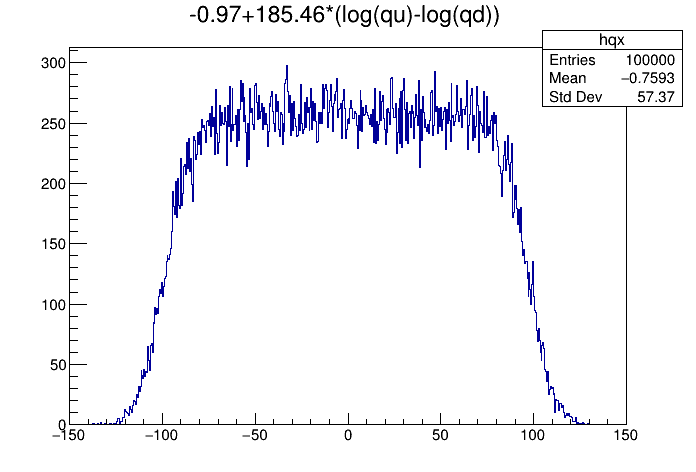

In [9]:
qxl = f1->GetParameter(1);
qxr = f2->GetParameter(1);
// qx = 200.0 / (qxr - qxl) * ((log(qu)-log(qd))-qxl) - 100.0
qp0 = 200.0 * qxl / (qxl - qxr) - 100.0;
qp1 = 200.0 / (qxr-qxl);
TString sqp0(Form("%5.2lf", qp0));
TString sqp1(Form("%5.2lf", qp1));
tree->Draw(sqp0+"+"+sqp1+"*"+"(log(qu)-log(qd)) >> hqx(600, -150, 150)");
delete f1, f2;
c1->Draw();



### 2.3 分析

将$t_x$和$q_x$先填入缓存的`xTree`中以方便使用

In [10]:
// 将数据tx和qx暂时填入xTree中
TTree* xTree = new TTree("xTree", "temporary tree to store tx and qx");
xTree->Branch("tx", &tx, "tx/D");
xTree->Branch("qx", &qx, "qx/D");
for (Long64_t jentry = 0; jentry < nentries; jentry++) {    //对事件进行遍历
    tree->GetEntry(jentry);     //将第jentry个事件数据填入对应变量(步骤3.中指向的变量)，每次变量值会变成当前事件对应的数据。
    // calculate new parameters
    // tx
    tx = td - tu;
    tx = tp0 + tp1 * tx;
    // qx
    qx = log(qu) - log(qd);
    qx = qp0 + qp1 * qx;

    xTree->Fill();
}
tree->AddFriend(xTree);

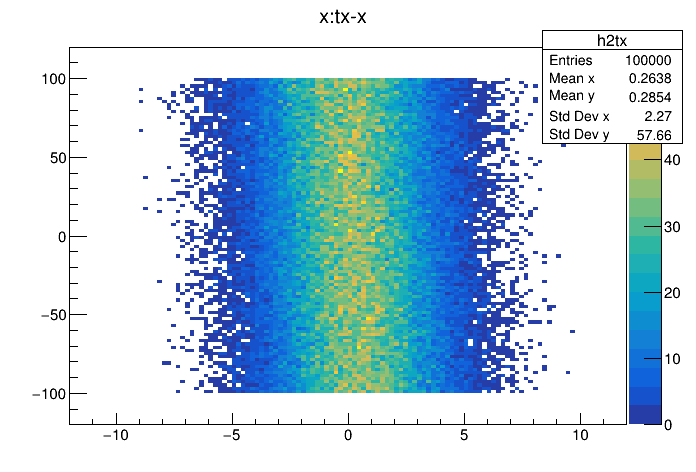

In [11]:
tree->Draw("x:tx-x >> h2tx(120, -12, 12, 120, -120, 120)", "", "colz");
c1->Draw();

**基本是直线，即残差和x无关**

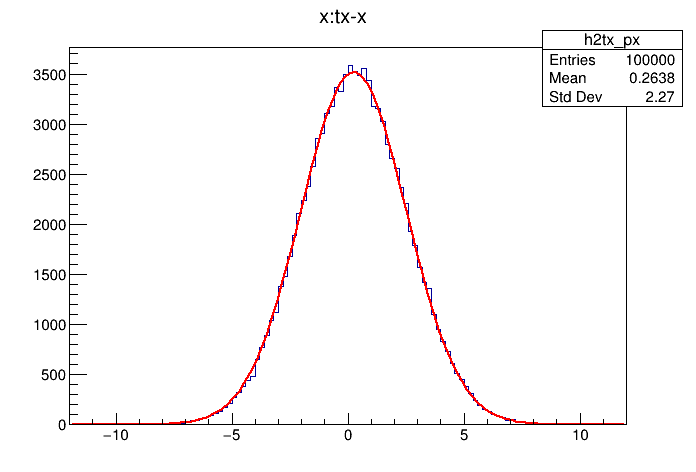

 FCN=80.3917 FROM MIGRAD    STATUS=CONVERGED      55 CALLS          56 TOTAL
                     EDM=3.46727e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.51478e+03   1.36489e+01   4.89818e-02  -7.14878e-06
   2  Mean         2.64222e-01   7.18100e-03   3.16340e-05   1.15157e-01
   3  Sigma        2.26845e+00   5.11504e-03   2.69600e-06  -1.55325e-01


In [12]:
TH2D *h2tx = (TH2D*)(gDirectory->Get("h2tx"));
TH1D *htxRes = h2tx->ProjectionX();
htxRes->Fit("gaus");
c1->Draw();

**如上图可见，$tx-x$ 的中心基本在0附近**

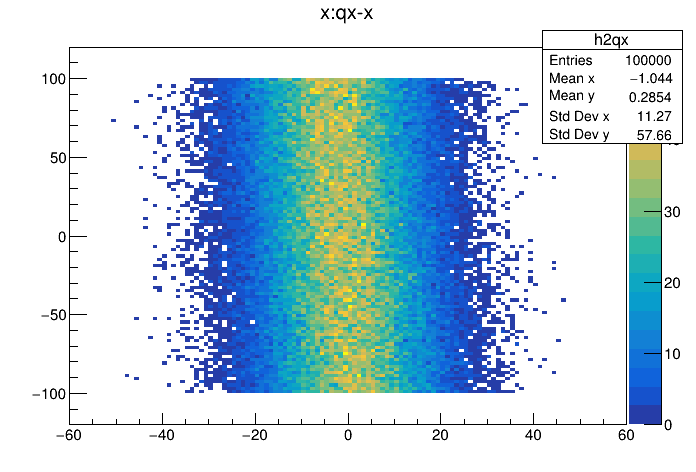

In [13]:
tree->Draw("x:qx-x>>h2qx(120, -60, 60, 120, -120, 120)", "", "colz");
c1->Draw();

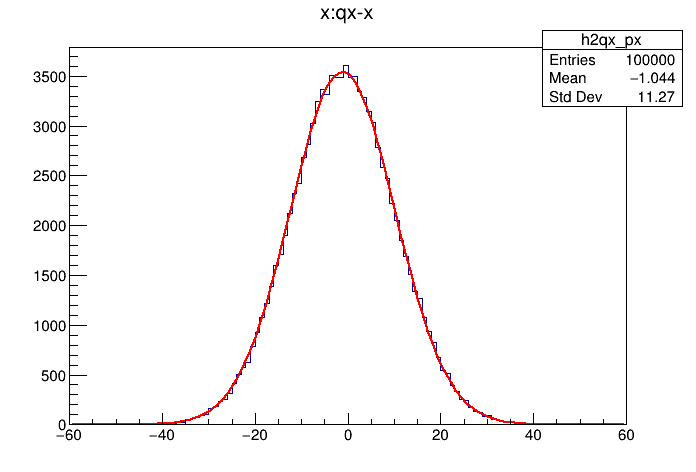

 FCN=84.3232 FROM MIGRAD    STATUS=CONVERGED      51 CALLS          52 TOTAL
                     EDM=7.13623e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     3.54000e+03   1.37369e+01   5.05116e-02  -6.84539e-06
   2  Mean        -1.04220e+00   3.56429e-02   1.60741e-04  -3.33709e-02
   3  Sigma        1.12606e+01   2.53234e-02   2.75365e-06  -1.58504e-01


In [14]:
TH2D *h2qx = (TH2D*)(gDirectory->Get("h2qx"));
TH1D *hqxRes = h2qx->ProjectionX();
hqxRes->Fit("gaus");
c1->Draw();

**$qx$ 和 $tx$ 对比，其分辨率略差，从 $qx$ 的分布可以看出其均匀性更差，并且`qdiff`的分bin也更少，因为分更多的bin时其微分分辨变差，找不到明确的峰值来确定左右边界。**

## 3 利用飞行时间计算中子能量

### 3.1a 利用探测器中心位置的光子进行绝对刻度

由
$$
TOF = (t_d + t_u) / 2 + TOF_{fix}
$$

只要知道某个点的 $TOF$和$CTOF = (t_d+t_u)/2$ 即可求得 $TOF_{fix}$，由于光子的速度已知为 $c$，选取打在探测器中心位置附近的光子，可通过其飞行距离502.5cm 求得其飞行时间 $realTof(0)$，并通过选择在中心附近的光子的 $CTOF$ 并拟合得到中心位置附近光子的 $CTOF$


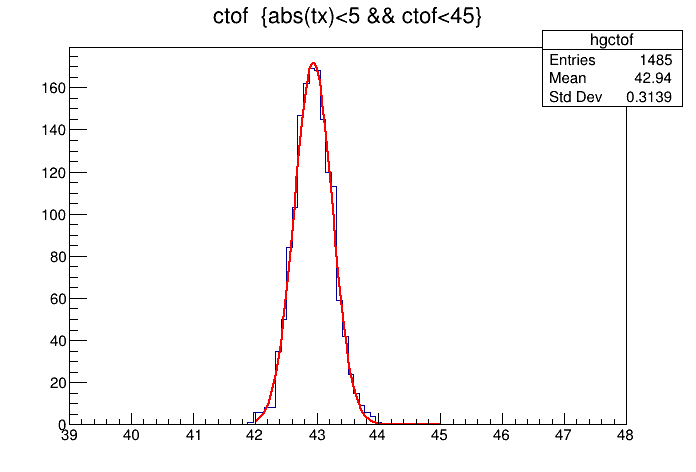

 FCN=24.3762 FROM MIGRAD    STATUS=CONVERGED      66 CALLS          67 TOTAL
                     EDM=3.72071e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.71800e+02   5.68590e+00   1.10611e-02  -5.60496e-06
   2  Mean         4.29487e+01   8.09763e-03   2.04795e-05  -9.55467e-03
   3  Sigma        3.05298e-01   6.24083e-03   1.29842e-05  -5.95492e-03
TOF-fix = -26.1875


In [15]:
// 修正TOF
tree->Draw("ctof >> hgctof(100, 39, 48)", "abs(tx)<5 && ctof<45", "goff");
TH1D *hgctof = (TH1D*)gDirectory->Get("hgctof");
f1 = new TF1("f1", "gaus", 42, 45);
hgctof->Fit(f1, "R");
Double_t tof0 = f1->GetParameter(1);
Double_t tofFix = realTof0 - tof0;                  // 得到修正系数tofFix
cout << "TOF-fix = " << tofFix << endl;
delete f1;
c1->Draw();

**得到的TOF修正参数为-26.2**

### 3.1b 利用拟合进行刻度

实际上我们进行刻度是求两个参数，第一个是修正项$TOF_{fix}$，另一个是归一化（到100cm）后的飞行时间，从而令光子的飞行时间都一样，而中子的飞行时间只和中子能量有关。对于光子

$$
NTOF = \frac{\left[(t_u+t_d)/2 + TOF_{fix}\right] d}{ \sqrt{\left(dD/2+D\right)^2+x^2}}
$$

其中 $d$ 是归一化的飞行距离，如果将 $x$ 看成自变量，$CTOF = (t_u +t_d) /2$ 看成因变量

$$
CTOF = -TOF_{fix} + NTOF \sqrt{(dD/2+D)^2 + x^2} / d
$$

可以以此函数拟合 $NTOF$ 和 $TOF_{fix}$

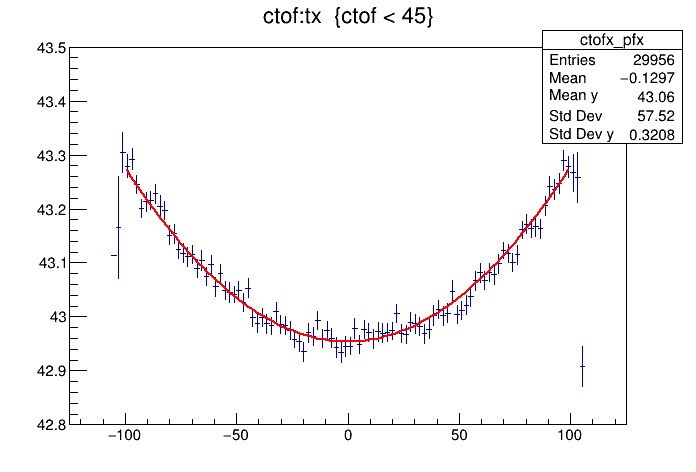

 FCN=85.0002 FROM MIGRAD    STATUS=CONVERGED      48 CALLS          49 TOTAL
                     EDM=6.05741e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  TOF_fix     -2.64291e+01   3.09141e-01   1.26024e-05  -1.30242e-05
   2  ntof         3.28843e+00   6.11280e-02   1.58059e-06   8.92683e-06


In [16]:
tree->Draw("ctof:tx >> ctofx", "ctof < 45", "goff");
TH2D *ctofx = (TH2D*)gDirectory->Get("ctofx");
TProfile *ctofxpx = ctofx->ProfileX();
ctofxpx->Sumw2(0);
ctofxpx->GetYaxis()->SetRangeUser(42.8, 43.5);
ctofxpx->Draw();
f1 = new TF1("f1", "-[0]+[1]*sqrt(x*x+502.5*502.5)/100.0", -100, 100);
f1->SetParName(0, "TOF_fix");
f1->SetParName(1, "ntof");
ctofxpx->Fit(f1, "R");
c1->Draw();
delete f1;

**拟合得到的 $TOF_{fix}$ 为 -26.4，和用绝对刻度方法得到的 -26.2 相近，而光子的归一化飞行时间3.3ns， 也符合实际情况。**

### 3.2 先将数据存起来
以上，已经求得计算新的数据$t_x, q_x, ntof, ce$的参数，可以先将参数存到新的树中再检验
<!-- 中子的能量考虑相对论效应后为
$$
E_n = m_n \left( \frac{1}{\sqrt{1 - \frac{v^2}{c^2}}} - 1\right) \\
v = \frac{d}{TOF}
$$ -->

In [17]:
for (Long64_t jentry = 0; jentry != nentries; ++jentry) {
    // tx and qx in xTree also getted as friend of tree
    tree->GetEntry(jentry);

    // 计算ntof，归一化到100cm
    ntof = (ctof + tofFix) * 100.0 / sqrt(502.5*502.5 + tx*tx);
    // 计算中子能量ce，不用考虑相对论效应
    if (ctof > 45) {
        // ce = Mn * (1.0 / sqrt(1.0 - 1.0 / (nc*nc*ntof*ntof)) - 1);
        ce = 72.29824 * 72.29824 / ntof / ntof;
    } else {
        ce = 0.0;
    }
    opt->Fill();
}
opt->Print();

******************************************************************************
*Tree    :tree      : tree                                                   *
*Entries :   100000 : Total =        10035300 bytes  File  Size =    8598123 *
*        :          : Tree compression factor =   1.16                       *
******************************************************************************
*Br    0 :tu        : tu/D                                                   *
*Entries :   100000 : Total  Size=     802780 bytes  File Size  =     753760 *
*Baskets :       25 : Basket Size=      32000 bytes  Compression=   1.06     *
*............................................................................*
*Br    1 :td        : td/D                                                   *
*Entries :   100000 : Total  Size=     802780 bytes  File Size  =     751915 *
*Baskets :       25 : Basket Size=      32000 bytes  Compression=   1.06     *
*...................................................

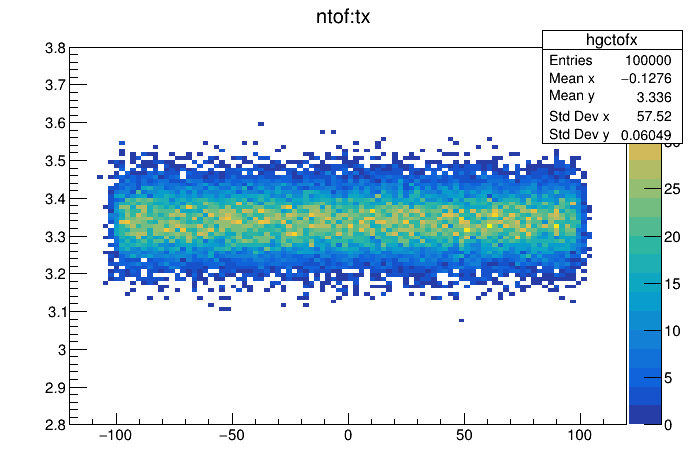

In [18]:
// 查看归一化后的光子的飞行时间
opt->Draw("ntof:tx >> hgctofx(100, -120, 120, 100, 2.8, 3.8)", "", "colz");
c1->Draw();

**经过归一化到1m的飞行距离后，飞行时间随不随入射位置变化，飞行时间均值为3.338ns，符合实际情况（光子飞行1m）**

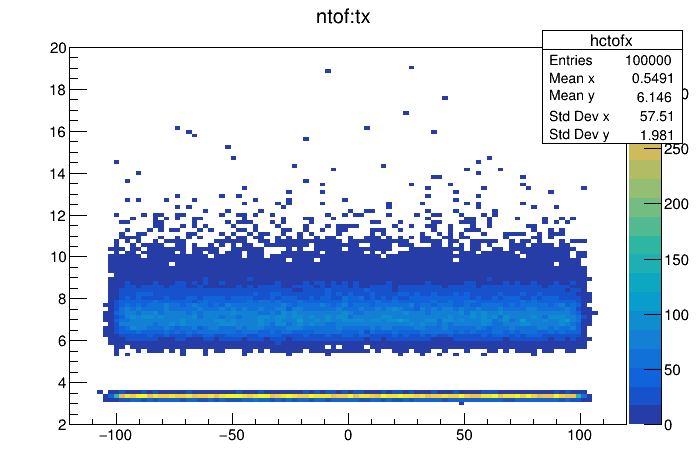

In [19]:
// 查看归一化后的光子和中子的飞行时间
opt->Draw("ntof:tx >> hctofx(100, -120, 120, 100, 2, 20)", "", "colz");
c1->Draw();

### 3.3 中子能量

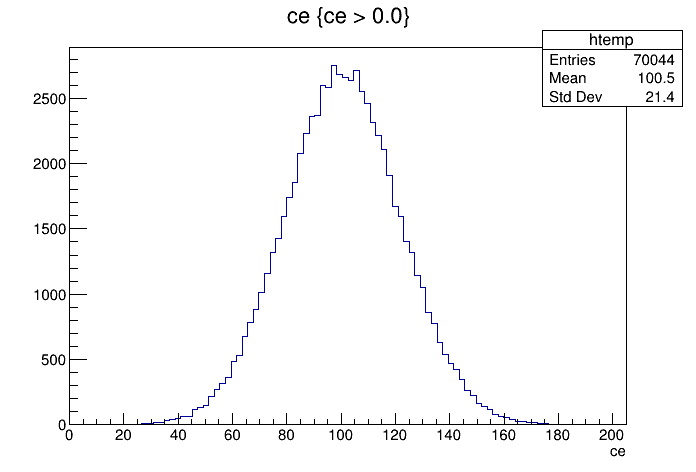

In [20]:
// 查看中子能量
opt->Draw("ce", "ce > 0.0", "");
c1->Draw();

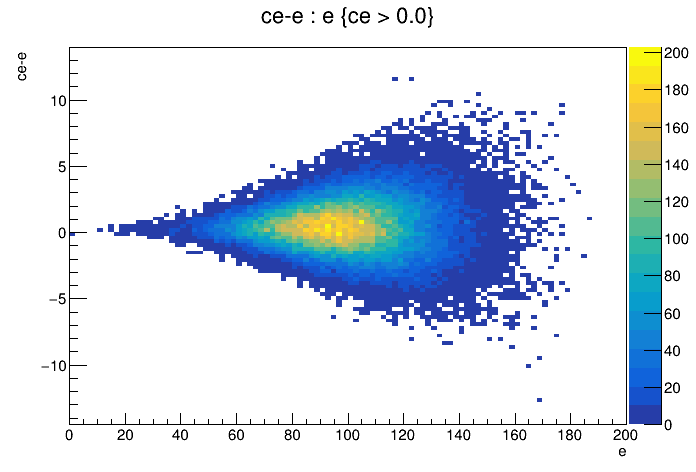

In [21]:
// 查看中子能量
opt->Draw("ce-e : e", "ce > 0.0", "colz");
c1->Draw();

**由图可见中子能量的残差随着中子能量提高而变大，而中子能量的计算公式为**
$$
E_n \propto ntof^{-2} 
$$
**其误差传递有**
$$
\sigma_{E_n} \propto ntof^{-3} \sigma_{ntof}
$$
**中子能量越大，归一化的飞行时间 $ntof$ 越小，如果 $\sigma_{ntof}$ 变化不大，则 $\sigma_{E_n}$ 就越大。而 $\sigma_{ntof}$ 主要来源于 $\sigma_{tx}$ 和 $\sigma_{td}$，两者在模拟中都是固定的分布，下图可以说明 $\sigma_{ntof}$ 确实不随中子能量 $e$ 变化。**

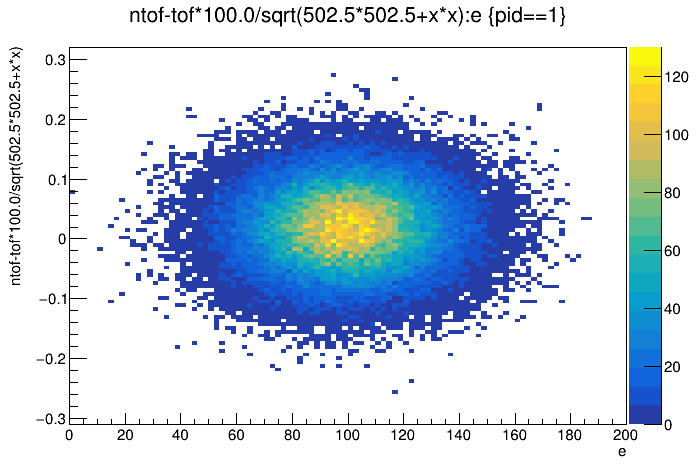

In [22]:
opt->Draw("ntof-tof*100.0/sqrt(502.5*502.5+x*x):e", "pid==1", "colz");
c1->Draw();

In [23]:
// 收尾
ipf->Close();
opt->Write();
opf->Close();